# Homework 7: DOA Estimation

Detecting the direction from which a signal arrived can be very useful. This is what allows Alexa to focus on what you're saying even in noisy environments, and gives you better WiFi signal when multiple devices are connected.

In this assignment, a signal is received at each sensor in a linear array of 16 sensors. The form of the signal is known to be $r = Acos(2\pi f_0 t + \phi_0)$, and the distance between the sensors is known. White, Gaussian, IID noise has been added to the signal at each sensor. Prior to receiving the data, each sample has been integrated over a 1ns period so that the input data for this assignment is $y_m = \frac{1}{T_0} \int_0^{T_0} r_m(t)e^{-j2\pi f_0t}dt$ for each sensor, $0 \rightarrow M-1$. This processing brings the signal to baseband where it is easier to process.

The angle of arrival of the signal will manifest itself as the delay between each sensor. To find this delay, one can then run a search over angles from -90 to 90 degrees (line arrays have bilateral symmetry). For each angle, a vector of delays, s, is created using:
$$ s_k = e^{-jk\Delta \phi}$$
$$ \Delta \phi = 2\pi f_0 \frac{d sin(\theta)}{c} $$

How well this vector of delays matches the observed signal can be calculated as $|s'Y|$. After performing the search, the angle with the highest value of $|s'Y|$ is chosen as the optimal angle of arrival.

Applying this algorithm to the provided data yields a predicted angle of arrival of 20°. Comparing the signal generated at this angle to the given data shows a good visual correlation. Testing the detector with generated signals from -90 to 90 degrees, the detector finds the correct angle for all cases.

In [14]:
pkg load mapping

In [161]:
f0 = 3e9;
d = 0.05;
c = 3e8;

## Note
Using the corrected numbers from the email, I still got the wrong numbers. Plugging in $d=5$ yields $d/\lambda = 50$. In order to get the correct answer, I needed to plug in d=0.05, yielding $d / \lambda = 0.5$

In [163]:
lambda = c/f0;
dlamb = .05/lambda

dlamb =  0.50000


In [18]:
load("hwk7.mat")

# Generate Clean Signal

In [171]:
function sig = generate(nsensors, A, d, delt_phi, angle, f0, c)
    dlamb = d / (c / f0);
    deltaphi = 2*pi*sind(angle)*dlamb ;
    s = exp(-i .* (0:nsensors-1)' .* deltaphi);
    sig = s * A * cos(2*pi*f0+delt_phi);
end

In [172]:
function [best_angle, cors] = find_angle(y, f0, c, d, nsensors, precision_degrees)
    count = 0;
    for angle=-90:precision_degrees:90
        count += 1;
        dlamb = d/(c/f0);
        deltaphi = 2*pi*dlamb*sind(angle);
        s = exp(-i .* (0:nsensors-1)' .* deltaphi);
        cor = abs(s'*y);
        cors(count) = cor;
    end
    [maxcor, idx] = max(cors);
    best_angle = (-90:precision_degrees:90)(idx);
end

## Test on Clean Data

In [173]:
sig = generate(10, 2, d, 0.0, 60, 3e9, 3e8)

sig =

   2.00000 - 0.00000i
  -1.82545 - 0.81715i
   1.33226 + 1.49167i
  -0.60653 - 1.90581i
  -0.22508 + 1.98729i
   1.01740 - 1.72189i
  -1.63213 + 1.15593i
   1.96196 - 0.38820i
  -1.94934 - 0.44730i
   1.59645 + 1.20471i



In [170]:
[angle, cors] = find_angle(sig, f0, c, d, 10, 1);
angle

angle =  60


In [152]:
for angle=-90:1:90
    sig = generate(10, 2, 5, 0, angle, 3e9, 3e8);
    [ang_found, corstest] = find_angle(sig, 3e9, 3e8, 5, 10, 0.1);
    if ang_found != angle
        strcat("Angle: ", num2str(ang_found), " != ", num2str(angle))
    end
end

ans = Angle:-90 !=90


## Run on Signal Data!

In [174]:
[angle, cors] = find_angle(Y, f0, c, d, 16, 1);
angle

angle =  20


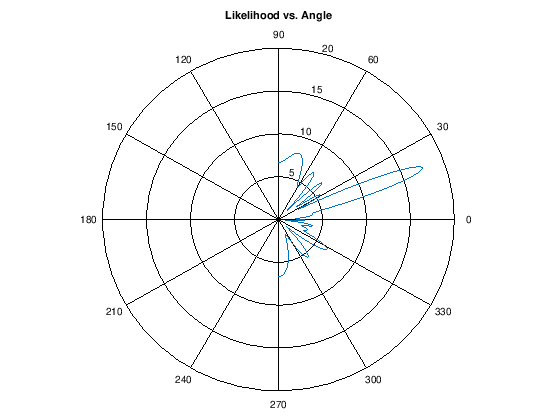

In [142]:
r = linspace(-pi / 2, pi / 2, length(cors));
polar(r, cors)
title("Likelihood vs. Angle")

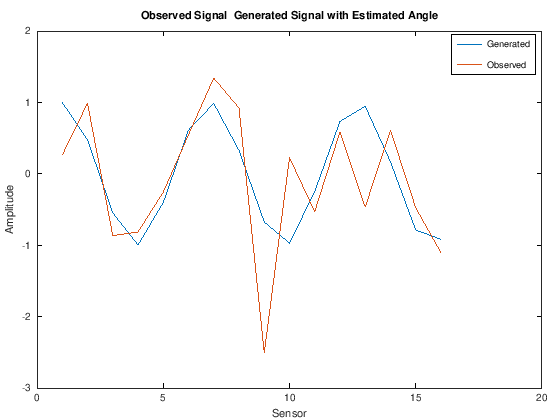

In [181]:
fake_signal = generate(16, 1, d, 0.0, 20, f0, c);
plot(real(fake_signal), 'DisplayName', 'Generated')
hold on
plot(real(Y), 'DisplayName', 'Observed')
title("Observed Signal & Generated Signal with Estimated Angle")
xlabel("Sensor")
ylabel("Amplitude")
legend